# Study of the multistage object detection and instant segmentation using `Detectron2`

The library (framework) [Detectron2](https://detectron2.readthedocs.io/notes/benchmarks.html) is the high API framework of solving multistage object detection and related issues within  `PyTorch`, in particular:
* `object detection`, 
* `instance segmentation`, 
* `keypoint detection`, 
* `panoptic segmentation`. 

The code for the library could be found [here](https://github.com/facebookresearch/Detectron2). 
<!-- В основе библиотеки лежат фреймворк pytorch и caffe2 (на котором написана [первая версия detectron](https://github.com/facebookresearch/Detectron)). -->

ALso it could be use full to study:
* official repository https://github.com/facebookresearch/Detectron2;
* comparison with other frameworks https://github.com/facebookresearch/detectron2/tree/master/projects;
* https://ai.facebook.com/blog/-detectron2-a-pytorch-based-modular-object-detection-library-/ - official website;
* previous version https://github.com/facebookresearch/Detectron/;
* information about installing Detectron2  https://detectron2.readthedocs.io/tutorials/install.html.



*Notation* 

If you do not have GPU, than it is highly recommended to use Google Colab or kaggle with GPU.


<img src="https://course.fast.ai/images/colab/04.png" width="350">


ALso you will need to install `Detectron 2` in both as colab as kaggle. You may find las example of installation  [here](https://colab.research.google.com/drive/16jcaJoc6bCFAQ96jDe2HwtXj7BMD_-m5) or here (https://detectron2.readthedocs.io/en/latest/tutorials/install.html). 

In our example we will use the following script
```python
        !pip install pyyaml==5.1

        import torch
        TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
        CUDA_VERSION  = torch.__version__.split("+")[-1]
        print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)

        !pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/$CUDA_VERSION/torch$TORCH_VERSION/index.html

 ```
    
After installing you will need to restart runtime
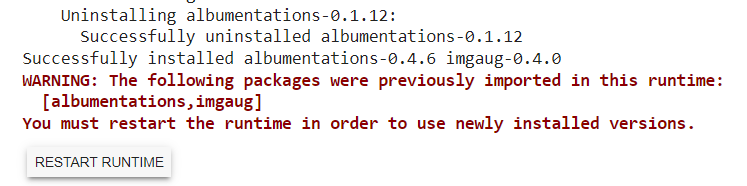


So, here we will restart automatically, using the following code:
```python
    import os
    os.kill(os.getpid(), 9)
```

In [1]:
import torch
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION  = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)

try:
    import pyyaml
except:
    !pip install pyyaml==5.1

# try:
#     from albumentations.pytorch import ToTensorV2
# except:
#     !pip install albumentations==0.4.6  
try:
    import urllib3
except 
    !pip3 install --upgrade urllib3==1.25

try:
    import detectron2
except:
    try:
        !pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/$CUDA_VERSION/torch$TORCH_VERSION/index.html
    except:
        ! git clone https://github.com/facebookresearch/detectron2.git
        python -m pip install -e detectron2
    import os
    os.kill(os.getpid(), 9)

torch:  1.10 ; cuda:  cu111
  Using cached urllib3-1.25-py2.py3-none-any.whl (149 kB)
Reason for being yanked: Broken release
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.25.11
    Uninstalling urllib3-1.25.11:
      Successfully uninstalled urllib3-1.25.11
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
requests 2.23.0 requires urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you have urllib3 1.25 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


import

In [2]:
import detectron2
import torch, torchvision

In [3]:
import numpy as np
import os, json, cv2, random
from PIL import Image
import matplotlib.pyplot as plt

# from google.colab.patches import cv2_imshow

In [4]:
from detectron2        import model_zoo
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data             import MetadataCatalog, DatasetCatalog 
from detectron2.structures       import BoxMode
from detectron2.data.datasets    import register_coco_instances, load_coco_json
from detectron2.utils.logger     import setup_logger
from detectron2.utils.visualizer import ColorMode
from detectron2.evaluation       import COCOEvaluator, inference_on_dataset
from detectron2.data             import build_detection_test_loader

In [5]:
def torch_stats(): 
    torch_version = ".".join(torch.__version__.split(".")[:2])
    print('torch version:',torch_version)
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print('Using device:', device)
    dtype = torch.float32
    
    if device.type == 'cuda':
        cuda_version  = torch.__version__.split("+")[-1]
        print("cuda: ", cuda_version)
        
        torch.set_default_tensor_type(torch.cuda.FloatTensor)
        print('Cuda is available:',torch.cuda.is_available())

        n_devices = torch.cuda.device_count()
        print('number of devices: %d'%(n_devices))

        for cnt_device in range(n_devices):
            print(torch.cuda.get_device_name(cnt_device))
            print('Memory Usage:')
            print('Allocated:', round(torch.cuda.memory_allocated(cnt_device)/1024**3,1), 'GB')
            print('Cached:   ', round(torch.cuda.memory_reserved(cnt_device)/1024**3,1), 'GB')


    torch.set_default_dtype(dtype) # float32
    print('default data type:',dtype)
    
    num_workers=os.cpu_count() #torch.get_num_threads()
    print ('available number of workers:',num_workers)
    
    return device, dtype, num_workers
#-------------------------------
def torch_seed(seed = 42, deterministic = True):
    random.seed(seed) # random and transforms
    np.random.seed(seed) #numpy
    torch.manual_seed(seed) #cpu
    torch.cuda.manual_seed(seed) #gpu
    torch.backends.cudnn.deterministic=deterministic #cudnn    

In [6]:
device, dtype, num_workers = torch_stats()
torch_seed(seed = 42, deterministic = True)

torch version: 1.10
Using device: cuda
cuda:  cu111
Cuda is available: True
number of devices: 1
Tesla T4
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
default data type: torch.float32
available number of workers: 2


In [6]:
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

import os
import copy
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import transforms, datasets
import torchvision.transforms as T

from torchsummary import summary

from tqdm.notebook import tqdm, trange

import pandas as pd


# from albumentations.pytorch import ToTensorV2
# import albumentations as A

import shutil
from urllib.request import urlretrieve
from torchvision.datasets.utils import download_and_extract_archive



---






The `Detectron 2` contains:
*  `Fast-R-CNN` variants for `object detection`;   
*  `Mask-R-CNN` variants for `instance segmentation`;  
*  `Mask-R-CNN` variants for `keypoint detection`; 
*  `Mask-R-CNN` variants for `panoptic segmentation`;
*  and some variants of `Cascade-Mask-R-CNN`,  `RetinaNet` and `Fast-R-CNN` with dilated convolution `DC5`.

The list with all available can be found [here](https://github.com/facebookresearch/detectron2/blob/main/MODEL_ZOO.md).

Also it could be taken by `detectron2.model_zoo.model_zoo` module with `_ModelZooUrls()` function.

Also it could be found several side project, based on the  `Detectron 2`  [`projects`](https://github.com/facebookresearch/detectron2/tree/main/projects).

All the architectures in the `Detectron 2` on the such popular datasets as [`Microsoft-COCO`](https://cocodataset.org/). You find some of them as built-in [here](https://detectron2.readthedocs.io/en/latest/tutorials/builtin_datasets.html).

In [8]:
from detectron2.model_zoo.model_zoo import _ModelZooUrls
mz = _ModelZooUrls()
print("\n".join(list(mz.CONFIG_PATH_TO_URL_SUFFIX.keys())))

COCO-Detection/faster_rcnn_R_50_C4_1x
COCO-Detection/faster_rcnn_R_50_DC5_1x
COCO-Detection/faster_rcnn_R_50_FPN_1x
COCO-Detection/faster_rcnn_R_50_C4_3x
COCO-Detection/faster_rcnn_R_50_DC5_3x
COCO-Detection/faster_rcnn_R_50_FPN_3x
COCO-Detection/faster_rcnn_R_101_C4_3x
COCO-Detection/faster_rcnn_R_101_DC5_3x
COCO-Detection/faster_rcnn_R_101_FPN_3x
COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x
COCO-Detection/retinanet_R_50_FPN_1x
COCO-Detection/retinanet_R_50_FPN_3x
COCO-Detection/retinanet_R_101_FPN_3x
COCO-Detection/rpn_R_50_C4_1x
COCO-Detection/rpn_R_50_FPN_1x
COCO-Detection/fast_rcnn_R_50_FPN_1x
COCO-InstanceSegmentation/mask_rcnn_R_50_C4_1x
COCO-InstanceSegmentation/mask_rcnn_R_50_DC5_1x
COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_1x
COCO-InstanceSegmentation/mask_rcnn_R_50_C4_3x
COCO-InstanceSegmentation/mask_rcnn_R_50_DC5_3x
COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x
COCO-InstanceSegmentation/mask_rcnn_R_101_C4_3x
COCO-InstanceSegmentation/mask_rcnn_R_101_DC5_3x
COCO-Insta

Let's check `Detectron2` for  [`COCO`](https://cocodataset.org/#home), image.

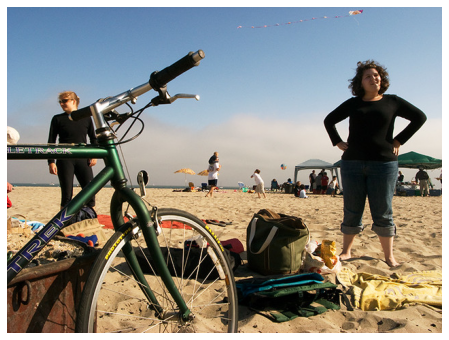

In [9]:
!wget http://farm4.staticflickr.com/3190/2582737708_d323925200_z.jpg -q -O image.jpg

image = np.asarray(Image.open("./image.jpg"))
plt.figure(figsize=(18,6)); plt.imshow(image); plt.axis('off'); plt.show()

For starting working with `Detectron2` you need to describe configuration of the model you want. <br> The basic configuration can be found here `get_cfg()`.

The full description of configuration can be found [here](https://detectron2.readthedocs.io/en/latest/modules/config.html#yaml-config-references).

In [10]:
cfg = get_cfg()

Let's start from  `faster rcnn` with `resnet 50` encoder.

In [11]:
config = model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_DC5_3x.yaml")
cfg.merge_from_file(config)

Also we need weights parameters. Pretrained one can be given using `get_checkpoint_url` method. We will take them, trained for the `COCO` dataset.

In [12]:
model_weights  =  model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_DC5_3x.yaml")

cfg.MODEL.WEIGHTS = model_weights

Also we will need to modify some configuration settings.
 * confidence (`score`) for `Non-Maximum Supression` (`NMS`, `SCORE_THRESH_TEST`). 
 * And threshold `IoU` for `NMS` (`NMS_THRESH_TEST`).
 




In [13]:
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7
cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST = 0.5



In [14]:
cfg.MODEL.ROI_HEADS

CfgNode({'NAME': 'StandardROIHeads', 'NUM_CLASSES': 80, 'IN_FEATURES': ['res5'], 'IOU_THRESHOLDS': [0.5], 'IOU_LABELS': [0, 1], 'BATCH_SIZE_PER_IMAGE': 512, 'POSITIVE_FRACTION': 0.25, 'SCORE_THRESH_TEST': 0.7, 'NMS_THRESH_TEST': 0.5, 'PROPOSAL_APPEND_GT': True})

So, now we are able to create predictor object based on the configuration we are describe

In [15]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

predictor = DefaultPredictor(cfg)


model_final_68d202.pkl: 663MB [00:16, 40.0MB/s]                           


So, let's take prediction.

The result is a dictionary with one field `instances`. In the case of object detection each  `instances` consists of `pred_boxes`, `scores`, `pred_classes`. Depends on the task the content could be different.


In [16]:
outputs = predictor(image)

print(outputs.keys())
print(outputs['instances']._fields.keys())

/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


dict_keys(['instances'])
dict_keys(['pred_boxes', 'scores', 'pred_classes'])


ALso we can visualize predictions, using `Visualizer` from `Detectron2`.


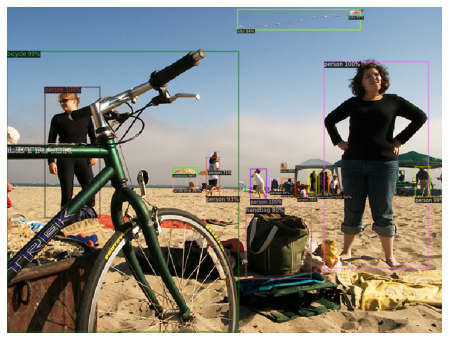

In [17]:
v = Visualizer(image, 
               MetadataCatalog.get(cfg.DATASETS.TEST[0]), 
               scale=1.2)

out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

plt.figure(figsize=(18,6)); plt.imshow(out.get_image()); plt.axis('off'); plt.show()

So also we can test `Mask-R-CNN`  for the `Instance Segmentation`.

model_final_9243eb.pkl: 144MB [00:08, 16.8MB/s]                           


dict_keys(['instances'])
dict_keys(['pred_boxes', 'scores', 'pred_classes', 'pred_masks'])


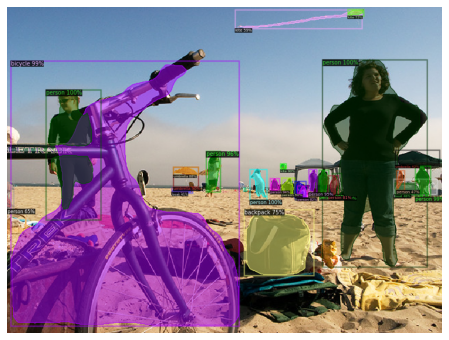

In [18]:
MODEL = "COCO-InstanceSegmentation/mask_rcnn_R_50_C4_1x.yaml"

cfg          = get_cfg()
model_config  = model_zoo.get_config_file(MODEL)
model_weights =  model_zoo.get_checkpoint_url(MODEL)

cfg.merge_from_file(model_config)
cfg.MODEL.WEIGHTS = model_weights
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.4 

predictor = DefaultPredictor(cfg)
outputs   = predictor(image)

print(outputs.keys())
print(outputs['instances']._fields.keys())

v = Visualizer(image, 
               MetadataCatalog.get(cfg.DATASETS.TEST[0]), 
               scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

plt.figure(figsize=(18,6)); plt.imshow(out.get_image()); plt.axis('off'); plt.show()

Additionally we can check  `Key Point Segmentation`. 

model_final_a6e10b.pkl: 237MB [00:13, 17.6MB/s]                           
/usr/local/lib/python3.7/dist-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
/usr/local/lib/python3.7/dist-packages/detectron2/structures/keypoints.py:224: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, u

dict_keys(['instances'])
dict_keys(['pred_boxes', 'scores', 'pred_classes', 'pred_keypoints', 'pred_keypoint_heatmaps'])


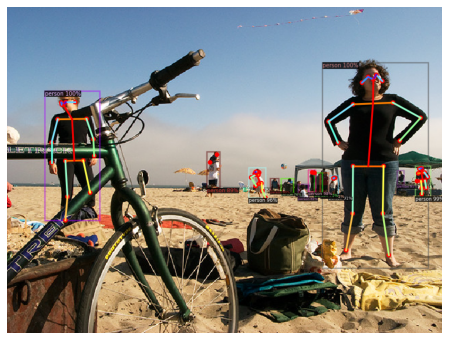

In [19]:
MODEL = "COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml"

# Inference with a keypoint detection model
cfg = get_cfg()   # get a fresh new config
cfg.merge_from_file(model_zoo.get_config_file(MODEL))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  # set threshold for this model
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(MODEL)
predictor = DefaultPredictor(cfg)
outputs = predictor(image)

print(outputs.keys())
print(outputs['instances']._fields.keys())

v = Visualizer(image, MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

plt.figure(figsize=(18,6)); plt.imshow(out.get_image()); plt.axis('off'); plt.show()

ANd check `Panoptic Segmentation`.

model_final_cafdb1.pkl: 261MB [00:09, 26.6MB/s]                           
/usr/local/lib/python3.7/dist-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride


24 dict_keys(['id', 'isthing', 'score', 'category_id', 'instance_id']) torch.Size([480, 640]) tensor(24, dtype=torch.int32)


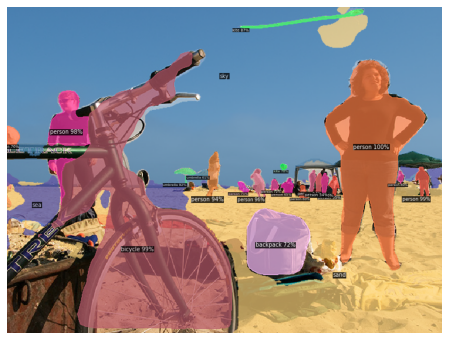

In [20]:
MODEL = "COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml"

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file(MODEL))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(MODEL)

predictor = DefaultPredictor(cfg)

panoptic_seg, segments_info = predictor(image)["panoptic_seg"]

print(len(segments_info), segments_info[0].keys(), panoptic_seg.shape,panoptic_seg.max())

v = Visualizer(image, MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)

out = v.draw_panoptic_seg_predictions(panoptic_seg.to("cpu"), segments_info)

plt.figure(figsize=(18,6)); plt.imshow(out.get_image()); plt.axis('off'); plt.show()

For better understanding let's try to describe the `Instant Segmentation` result parsing.

In [75]:
def plot_instant(image, mask, bbox):

    fig, axs = plt.subplots(1, 4, figsize = (18,6))
    image_ = np.copy(np.asarray(image)).astype(float)/image.max()
    
    # Ground Truth    
    axs[0].imshow(np.clip(image_,0,1), 'gray')
    axs[0].axis('off'); axs[0].set_title('Original Image')
    #----------------------------

    # Semantic Segmentaion
    mask_ = np.asarray(mask).sum(2)
    mask_[mask_>0]=255
    axs[1].imshow(mask_, 'gray')
    axs[1].axis('off'); axs[1].set_title('Semantic Segmentaion')  
    #----------------------------

    # Instance Segmentation
    out  = np.zeros((*mask.shape[:2],3),dtype=float)
    for i,mask_ in enumerate(mask.transpose((2,0,1))):
        ch_  = i%3 #color
        mask_ = mask_*(np.random.rand()*0.5 + 0.5)   #color      
        out[:,:,ch_]  = out[:,:,ch_]*0.9 + mask_[:,:] #color
   
    axs[2].imshow(np.clip(out/out.max(),0,1), 'gray')
    axs[2].axis('off'); axs[2].set_title('Instance Segmentation')  
    #----------------------------

    # Object Detection BBoxes
    bbox_ = np.asarray(bbox)
    axs[3].imshow(np.clip(image_,0,1), 'gray')
    for box_ in bbox_:
        bb = patches.Rectangle(xy     = (box_[0],box_[1]), 
                               width  = box_[2]-box_[0],
                               height = box_[3]-box_[1], 
                               linewidth=2, 
                               edgecolor="blue", 
                               facecolor="none")
        axs[3].add_patch(bb)  
    axs[3].axis('off'); axs[3].set_title('Object Detection')

    plt.tight_layout()
    plt.show()

In [22]:
MODEL = "COCO-InstanceSegmentation/mask_rcnn_R_50_C4_1x.yaml"

cfg          = get_cfg()
model_config  = model_zoo.get_config_file(MODEL)
model_weights =  model_zoo.get_checkpoint_url(MODEL)

cfg.merge_from_file(model_config)
cfg.MODEL.WEIGHTS = model_weights

cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.4 


predictor = DefaultPredictor(cfg)
outputs   = predictor(image)

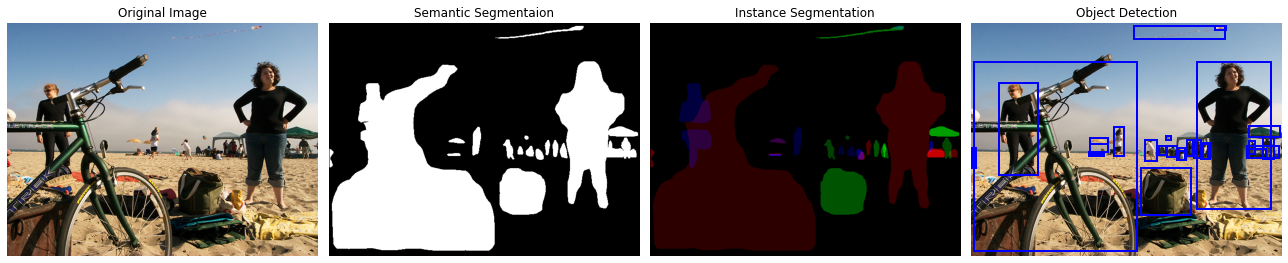

In [23]:
fields = outputs['instances']._fields
masks = fields['pred_masks'].detach().data.cpu().numpy().transpose((1,2,0))
# print(type(masks), masks.shape)
boxes = fields['pred_boxes'].tensor.detach().data.cpu().numpy()
# print(type(boxes), boxes.shape)
plot_instant(image, masks, boxes)

**Training ```MASK RCNN``` for instance segmentation** 






Here we can take 1-class dataset [the balloon dataset](https://github.com/matterport/Mask_RCNN/tree/master/samples/balloon). This dataset was proposed to test `Mask-R-CNN` in the original work.

In [24]:
# download, decompress the data
url = "https://github.com/matterport/Mask_RCNN/releases/download/v2.1/balloon_dataset.zip"

root_directory = os.path.join(os.getcwd(),'')

archive_name = url.split('/')[-1]
dataset_directory = os.path.join(root_directory, archive_name)
# dataset_directory = os.path.splitext(dataset_directory)[0]
dataset_directory = os.path.join(root_directory, 'balloon')

download_and_extract_archive(url, root_directory)

  0%|          | 0/38741381 [00:00<?, ?it/s]

Extracting /content/balloon_dataset.zip to /content/


In [25]:
# !wget https://github.com/matterport/Mask_RCNN/releases/download/v2.1/balloon_dataset.zip
# !unzip balloon_dataset.zip > /dev/null

Let's check the directories `val` and `train`.

In [26]:
content = os.listdir(dataset_directory)
print(content)

['val', 'train']


SO, for working with such frameworks as `Detectron` we need to have standard format of dataset. The most common chose is the   `json` with `COCO` structure. Here we will transform the input labeling for balloon dataset to truncated version of COCO labels. The full description can be found [here](https://cocodataset.org/#format-data). The description contains the following fields:
* `file_name` - name of files;
* `image_id`  -  identification number, starting from 1;
* `height`, `width` - shape of image;
* `annotations` - image annotation, for each instance:
    * `bbox` - labels for bounding box;
    * `bbox_mode` - type of labels, for instance `x0,y0,W,H` (`XYWH_ABS`) for set left upper point, width and height, or x0y0x1y1 for set bbox as left upper and lower right points,  [you may find variants here](https://github.com/facebookresearch/detectron2/blob/main/detectron2/structures/boxes.py);
    * `segmentation` - description of segmentation mask;
    * `category_id` - class of the object.

<!-- Также отметим, что в оригинальном формате  `COCO` используется представление рамки в виде `XYWH`, то есть координаты левого угла, ширина и высота объекта. Однако, можно будет заметиь, что такое представление будет неудобным при оценке результатов работы сети. -->

In [27]:
from detectron2.structures import BoxMode

def balloon2COCO(img_dir):
    json_file = os.path.join(img_dir, "via_region_data.json")
    with open(json_file) as f:
        imgs_anns = json.load(f)

    dataset_dicts = []
    for idx, v in enumerate(imgs_anns.values()):
        record = {}
        
        filename = os.path.join(img_dir, v["filename"])
        height, width = np.asarray(Image.open(filename)).shape[:2]
        
        record["file_name"] = filename
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width
      
        annos = v["regions"]
        objs = []
        for _, anno in annos.items():
            assert not anno["region_attributes"]
            anno = anno["shape_attributes"]
            px = anno["all_points_x"]
            py = anno["all_points_y"]
            poly = [(x, y) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]

            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px)-np.min(px), np.max(py)-np.min(py)],
                "bbox_mode": BoxMode.XYWH_ABS,
                "segmentation": [poly],
                "category_id": 0,
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

In [28]:
val_dir   = os.path.join(dataset_directory, 'val')
train_dir = os.path.join(dataset_directory, 'train')

So, now we can register dataset for the Detectron [list of datasets](https://detectron2.readthedocs.io/tutorials/datasets.html) .

*Actually for ```COCO``` enough to use the following code*

```python
from detectron2.data.datasets import register_coco_instances
register_coco_instances("my_dataset_train", {}, "json_annotation_train.json","path/to/image/dir")
register_coco_instances("my_dataset_val", {}, "json_annotation_val.json", "path/to/image/dir")
```
but implement the full way.

Also, the drawback, that if you register once, you  could not simply change data. Thus, before register dataset we will check and delete previous version if it is necessary.

In [29]:
try:
    DatasetCatalog.pop("balloon_train")
except:
    pass

try:  
    DatasetCatalog.pop("balloon_val")
except:
    pass  

In [30]:

try:  
    DatasetCatalog.register("balloon_train", lambda : balloon2COCO("balloon/train"))
except:
    print('Probably data %s have been already registred')

try:  
    DatasetCatalog.register("balloon_val", lambda : balloon2COCO("balloon/val"))
except:
    print('Probably data %s have been already registred')    

MetadataCatalog.get("balloon_train").set(thing_classes=["balloon"])
MetadataCatalog.get("balloon_val").set(thing_classes=["balloon"])

Metadata(name='balloon_val', thing_classes=['balloon'])

So, now we can check that it work

In [31]:
balloon_metadata = MetadataCatalog.get("balloon_train")
dataset_dicts    = balloon2COCO("balloon/train")

In [32]:
balloon_metadata.as_dict()

{'name': 'balloon_train', 'thing_classes': ['balloon']}

In [33]:
print('N Train',len(dataset_dicts))
print(dataset_dicts[0].keys())

N Train 61
dict_keys(['file_name', 'image_id', 'height', 'width', 'annotations'])


balloon/train/2937599387_80e7d6e050_b.jpg


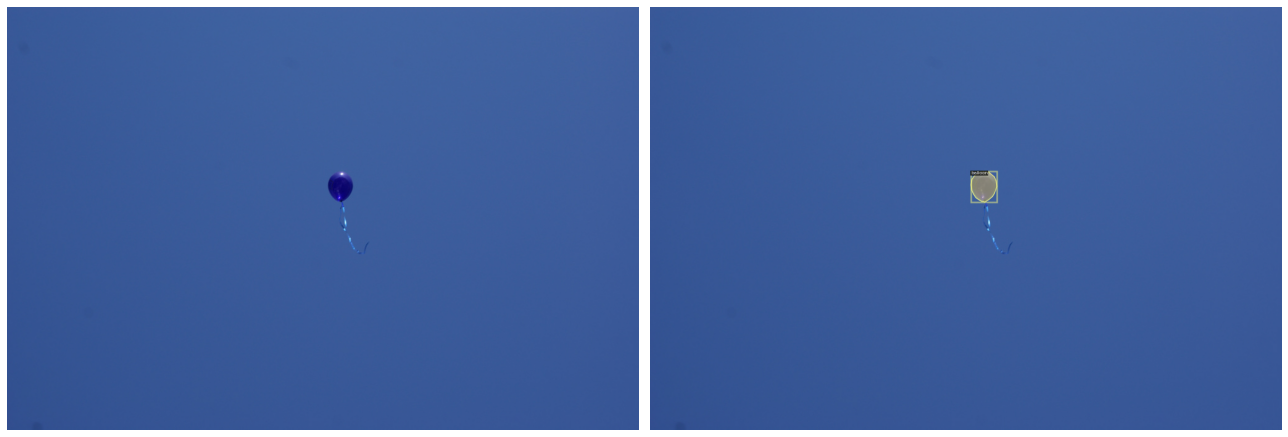

balloon/train/15717689633_5f7f78c28e_k.jpg


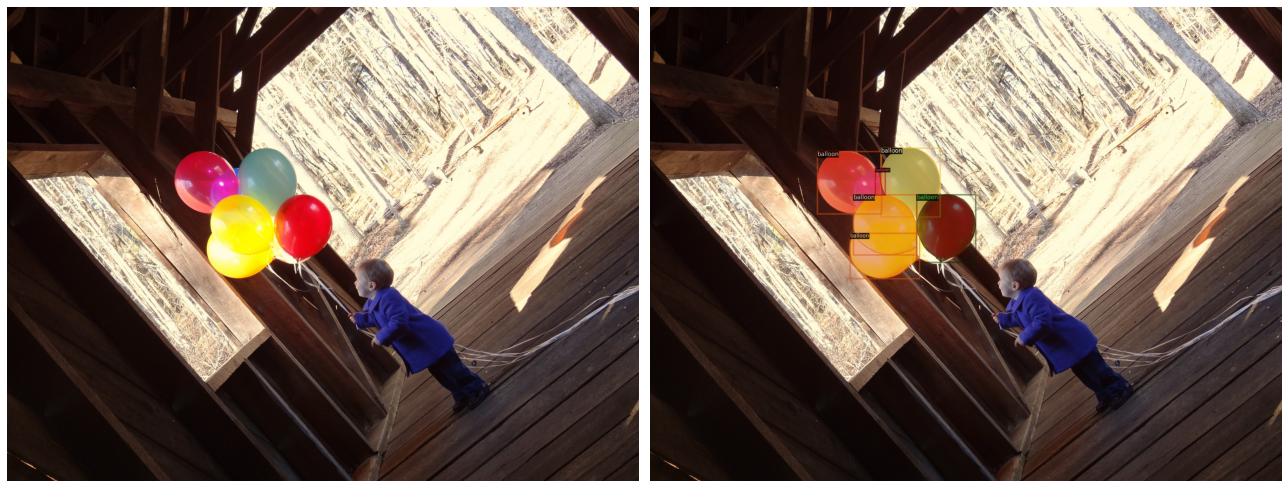

In [34]:
for d in random.sample(dataset_dicts, 2):    
    img   = Image.open(d["file_name"])
    _,axs = plt.subplots(1,2,figsize=(12,8))    
    axs[0].imshow(img); axs[0].axis('off')    
    visualizer = Visualizer(img, metadata=balloon_metadata, scale=1)    
    out = visualizer.draw_dataset_dict(d)
    axs[1].imshow(out.get_image()); axs[1].axis('off')
    plt.tight_layout();plt.show()

Also we can parsing the data by our self.
for this we will use official library for working with COCO, which you may find [here](https://github.com/cocodataset/cocoapi/tree/master/PythonAPI/pycocotools).

In [58]:
from pycocotools import mask as cocoutils

def get_masks(image_anno):
    h = image_anno['height'] 
    w = image_anno['width' ]
    mask_anns = image_anno['annotations']
    mask = np.zeros((h,w, len(mask_anns)))
    for i,ann in enumerate(mask_anns):
        mask[:,:,i] = _ann2mask(ann,h,w)
    return mask

def _ann2mask(ann, h,w):
    segm = ann['segmentation']
    rles = cocoutils.frPyObjects(segm, h, w)
    rle  = cocoutils.merge(rles)
    instant_mask = cocoutils.decode(rle)  
    return instant_mask

def get_bboxes(image_anno):
    bboxes = np.zeros((len(image_anno['annotations']),4),dtype=int)#x0,y0,w,h

    for i,ann in enumerate(image_anno['annotations']):
        bboxes[i] = ann['bbox']
    bboxes[:,2] = bboxes[:,0]+bboxes[:,2] #x-max
    bboxes[:,3] = bboxes[:,1]+bboxes[:,3] #y-max
    return bboxes 

balloon/train/34020010494_e5cb88e1c4_k.jpg


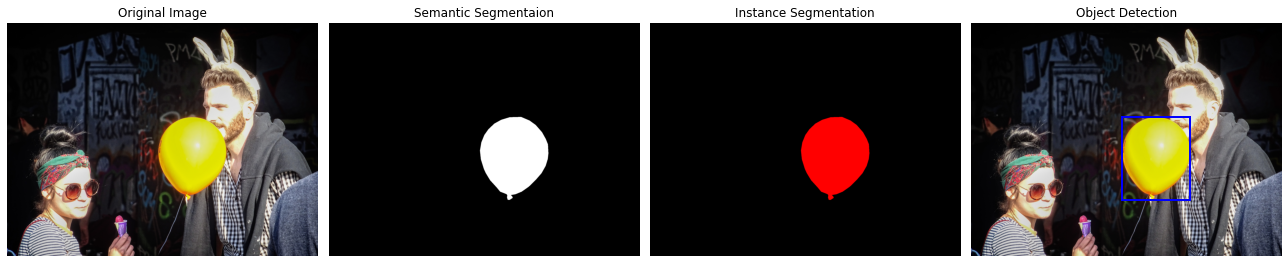

In [36]:

d = dataset_dicts[0]
print(d['file_name'])

image = np.asarray(Image.open(d["file_name"]))


masks = get_masks(d)
boxes = get_bboxes(d)

plot_instant(image, masks, boxes)

So, now we are able to train the model. Generally it is enough to use `DefaultTrainer` for this.  However, we will use  `CustomTrainer` for showing how to add something to the task. Here we will adding augmentation of the data. 

In [37]:
from detectron2.engine import DefaultTrainer

In [38]:
from detectron2.data import build_detection_test_loader, build_detection_train_loader

class CustomTrainer(DefaultTrainer):
    @classmethod
    def build_train_loader(cls, cfg):
        return build_detection_train_loader(cfg, mapper=custom_mapper)

In [39]:
from detectron2.data import detection_utils as utils
import detectron2.data.transforms as T
import copy
import torch

def custom_mapper(dataset_dict):
    dataset_dict = copy.deepcopy(dataset_dict)  # it will be modified by code below
    
    image = utils.read_image(dataset_dict["file_name"], format="BGR")
    
    transform_list = [
                        T.Resize((800,600)),
                        T.RandomBrightness(0.8, 1.8),
                        T.RandomContrast(0.6, 1.3),
                        T.RandomSaturation(0.8, 1.4),
                        T.RandomRotation(angle=[90, 90]),
                        T.RandomLighting(0.7),
                        T.RandomFlip(prob=0.4, horizontal=False, vertical=True),
                    ]
    
    image, transforms = T.apply_transform_gens(transform_list, image)

    dataset_dict["image"] = torch.as_tensor(image.transpose(2, 0, 1).astype("float32"))

    annos = [
        utils.transform_instance_annotations(obj, transforms, image.shape[:2])
        for obj in dataset_dict.pop("annotations")
        if obj.get("iscrowd", 0) == 0
    ]

    instances = utils.annotations_to_instances(annos, image.shape[:2])
    
    dataset_dict["instances"] = utils.filter_empty_instances(instances)
    
    return dataset_dict



So, also we need to add information about training settings.
<br>
* configuration of the model  `mask_rcnn_R_50_FPN_3x`;
* dataset ```balloon_train```;
* number of iterations `300` (epochs);
* batch size `2` ;
* number of classes `1`.



In [40]:
BATCH = 2

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("balloon_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = BATCH
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 300    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)

Also we need to add output directory path `./output` (`cfg.OUTPUT_DIR`).

We set mode of training from beginning ( `trainer.resume_or_load(resume=False)`). If you will ant to continue training, then set `resume` to `True`. 

In [41]:
import torch.multiprocessing as mp
mp.set_start_method('spawn', force=True)

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True);
trainer = CustomTrainer(cfg)#DefaultTrainer(cfg);

trainer.resume_or_load(resume=False)

[04/24 11:11:34 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_f10217.pkl: 178MB [00:11, 15.8MB/s]                           
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to i

So, training

In [42]:
trainer.train()

[04/24 11:11:52 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.7/dist-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride


[04/24 11:12:07 d2.utils.events]:  eta: 0:02:06  iter: 19  total_loss: 2.096  loss_cls: 0.6339  loss_box_reg: 0.6881  loss_mask: 0.6744  loss_rpn_cls: 0.05777  loss_rpn_loc: 0.0136  time: 0.4640  data_time: 0.2655  lr: 1.6068e-05  max_mem: 2109M
[04/24 11:12:16 d2.utils.events]:  eta: 0:01:59  iter: 39  total_loss: 1.828  loss_cls: 0.5268  loss_box_reg: 0.7036  loss_mask: 0.6013  loss_rpn_cls: 0.02702  loss_rpn_loc: 0.007314  time: 0.4594  data_time: 0.0129  lr: 3.2718e-05  max_mem: 2109M
[04/24 11:12:26 d2.utils.events]:  eta: 0:01:49  iter: 59  total_loss: 1.645  loss_cls: 0.4183  loss_box_reg: 0.6003  loss_mask: 0.5094  loss_rpn_cls: 0.04575  loss_rpn_loc: 0.02179  time: 0.4643  data_time: 0.0136  lr: 4.9367e-05  max_mem: 2109M
[04/24 11:12:35 d2.utils.events]:  eta: 0:01:40  iter: 79  total_loss: 1.523  loss_cls: 0.3382  loss_box_reg: 0.6658  loss_mask: 0.3873  loss_rpn_cls: 0.02084  loss_rpn_loc: 0.01288  time: 0.4679  data_time: 0.0132  lr: 6.6017e-05  max_mem: 2109M
[04/24 11:12

If you want to use `tensorboard` uncomment the following

In [43]:
# Look at training curves in tensorboard:
# %load_ext tensorboard
# %tensorboard --logdir output

The results of the training are: the file with weights `model_final.pth` and `metrics.json`.

**The model evaluation**<br><br>

So now we can describe predictor object for our model.


In [80]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
cfg.DATASETS.TEST = ("balloon_val", )
predictor = DefaultPredictor(cfg)

In [81]:
from detectron2.utils.visualizer import ColorMode
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

/usr/local/lib/python3.7/dist-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride


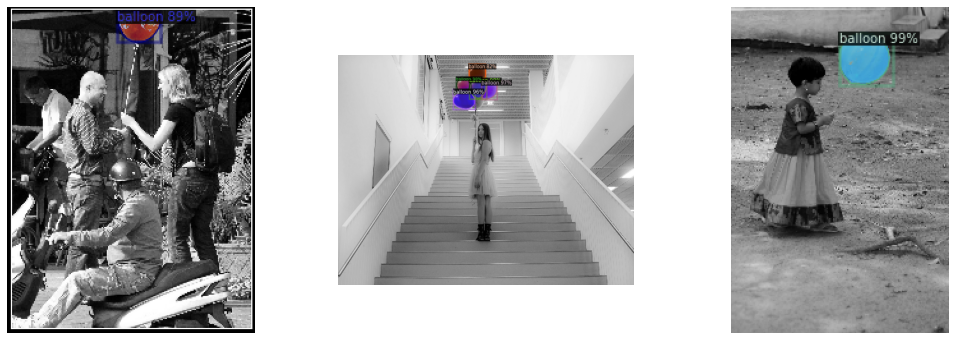

In [82]:
dataset_dicts = balloon2COCO("balloon/val")

_, axs = plt.subplots(1,3,figsize=(18,6))

for i,d in enumerate(random.sample(dataset_dicts, 3)):    
    im = np.asarray(Image.open(d["file_name"]))
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=balloon_metadata, 
                   scale=0.25, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    axs[i].imshow(out.get_image()); axs[i].axis('off'); 
plt.show()

Also let's estiamte the  accuracy, here it could be the average precision, AP and average recall, AR.

In [47]:
evaluator  = COCOEvaluator(dataset_name = "balloon_val", 
                           tasks        = ("bbox", "segm"), 
                           distributed  = False, 
                           output_dir   = "./output/")

[04/24 11:14:22 d2.evaluation.coco_evaluation]: Trying to convert 'balloon_val' to COCO format ...
[04/24 11:14:22 d2.data.datasets.coco]: Converting annotations of dataset 'balloon_val' to COCO format ...)
[04/24 11:14:23 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[04/24 11:14:23 d2.data.datasets.coco]: Conversion finished, #images: 13, #annotations: 50
[04/24 11:14:23 d2.data.datasets.coco]: Caching COCO format annotations at './output/balloon_val_coco_format.json' ...


In [48]:
val_loader = build_detection_test_loader(cfg, "balloon_val")

[04/24 11:14:23 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|  balloon   | 50           |
|            |              |
[04/24 11:14:23 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[04/24 11:14:23 d2.data.common]: Serializing 13 elements to byte tensors and concatenating them all ...
[04/24 11:14:23 d2.data.common]: Serialized dataset takes 0.02 MiB


In [49]:
print(inference_on_dataset(trainer.model, val_loader, evaluator))

# another equivalent way to evaluate the model is to use `trainer.test`

[04/24 11:14:23 d2.evaluation.evaluator]: Start inference on 13 batches


/usr/local/lib/python3.7/dist-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride


[04/24 11:14:30 d2.evaluation.evaluator]: Inference done 11/13. Dataloading: 0.0022 s/iter. Inference: 0.1350 s/iter. Eval: 0.0588 s/iter. Total: 0.1960 s/iter. ETA=0:00:00
[04/24 11:14:31 d2.evaluation.evaluator]: Total inference time: 0:00:02.336418 (0.292052 s / iter per device, on 1 devices)
[04/24 11:14:31 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:01 (0.132326 s / iter per device, on 1 devices)
[04/24 11:14:31 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[04/24 11:14:31 d2.evaluation.coco_evaluation]: Saving results to ./output/coco_instances_results.json
[04/24 11:14:31 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
[04/24 11:14:31 d2.evaluation.fast_eval_api]: Evaluate annotation type *bbox*
[04/24 11:14:31 d2.evaluation.fast_eval_api]: COCOeval_opt.evaluate() finished in 0.01 seconds.
[04/24 11:14:31 d2.evaluation.

Also we can save the model 

In [90]:
path2cfg = os.path.join(cfg.OUTPUT_DIR,'config.yml')
with open(path2cfg, 'w+') as f:
    f.write(cfg.dump())

ANd load the model config using `merge_from_file()`.

In [91]:
from detectron2.config import get_cfg

cfg = get_cfg()
cfg.merge_from_file(path2cfg)

The trained model can be created as `PyTorch` one using `build_model()` function, and weight uploaded to it with `DetectionCheckpointer()`. 

In [92]:
from detectron2.modeling import build_model
from detectron2.checkpoint import DetectionCheckpointer

model = build_model(cfg)
DetectionCheckpointer(model).load("./output/model_final.pth")

{'iteration': 299,
 'trainer': {'hooks': {'LRScheduler': {'base_lrs': [0.00025],
    'last_epoch': 300}},
  'iteration': 299}}

So now we can chwck how this model work. The model expected the  `List[Dict[str, torch.Tensor]]` structure of input, wher `str` need to be `"image"`, and `tensor`, image need to be in `PyTorch` format `(CxHxW)`. 

You can find more about using detectron models with pytorch  [here](https://detectron2.readthedocs.io/en/latest/tutorials/models.html).



In [120]:
n_samples = 3
dataset_dicts = balloon2COCO("balloon/val")

imgs = []
for d in random.sample(dataset_dicts, n_samples):    
    im = np.asarray(Image.open(d["file_name"]))
    im = torch.as_tensor(im.transpose((2,0,1))).to(device)
    imgs += [{"image":im}]




So, let's evaluate the model as usual in vanilla  `PyTorch`

In [121]:
model.eval()
with torch.no_grad():
    outs = model.forward(imgs)

print(len(outs))

/usr/local/lib/python3.7/dist-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride


3


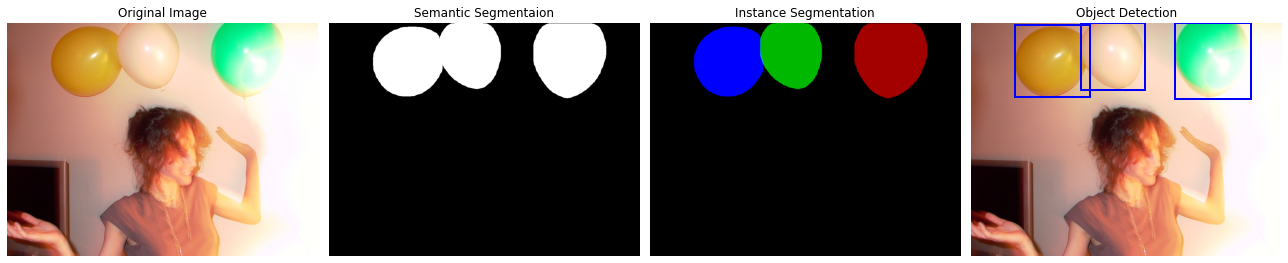

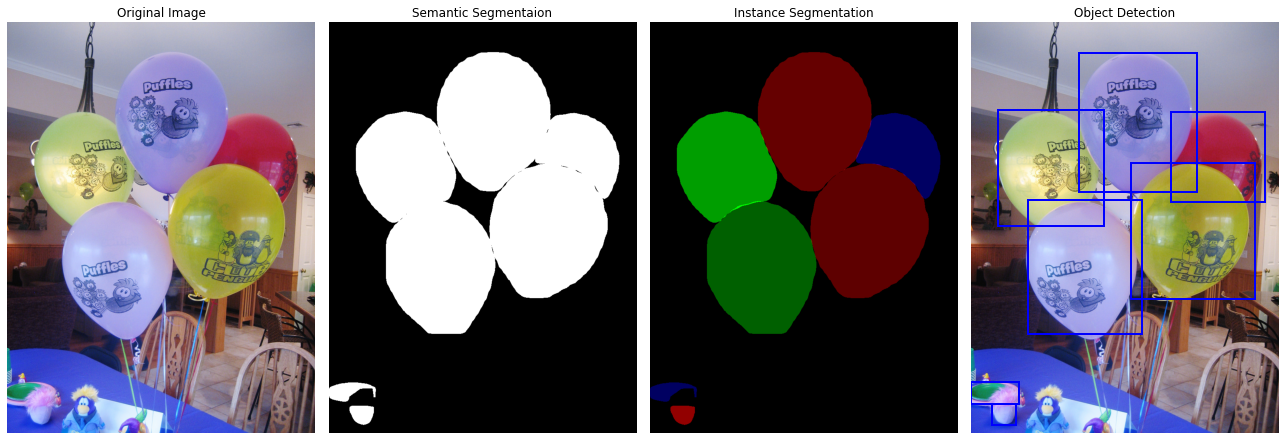

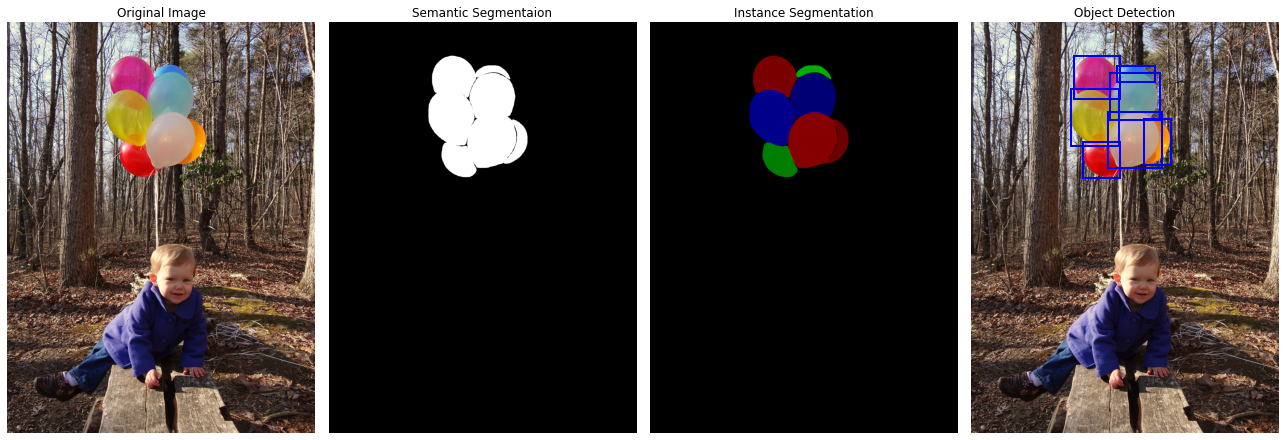

In [122]:
for im,target in zip(imgs,outs ):   
    image = im['image'].data.cpu().numpy().transpose((1,2,0))
    fields = target['instances']._fields
    masks = fields['pred_masks'].detach().data.cpu().numpy().transpose((1,2,0))

    boxes = fields['pred_boxes'].tensor.detach().data.cpu().numpy()

    plot_instant(image, masks, boxes)

**Exercise 1**
1. Try to improve accuracy for balloon dataset using models from `model_zoo`;
2. Try to solve the balloon as `object detection` problem.
3.   ADVANCED (not obligated) Train one of the models for the window detection dataset problem
https://github.com/InformationSystemsFreiburg/image_segmentation_japan/raw/master/buildings.zip
<!-- as hint you may use this link https://rosenfelder.ai/Instance_Image_Segmentation_for_Window_and_Building_Detection_with_detectron2/ -->
*the dataset has COCO format

<!-- 
3.
 Try to build an instance segmentation model for the  blood cells dataset, that you may find here: https://public.roboflow.com/object-detection/bccd
<!-- as hint you may use this link https://blog.roboflow.com/how-to-train-detectron2/ 
*Note* you will need to register for download data, please download data in the COCO format
https://colab.research.google.com/drive/1-TNOcPm3Jr3fOJG8rnGT9gh60mHUsvaW#scrollTo=QvbWgc7HhfWi -->

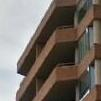

**Exercise 2**
1. Let's take the [`PennFudanPed`](https://www.cis.upenn.edu/~jshi/ped_html/) dataset.
2. Try to train one of the `Detectron2` model for it.

*Notation* this dataset proposed as example for training Mask-R-CNN in the vanilla `PyTorch` [here](https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html) and [here](https://colab.research.google.com/github/pytorch/tutorials/blob/gh-pages/_downloads/torchvision_finetuning_instance_segmentation.ipynb). 

For transform the [`PennFudanPed`] data to the COCO format you may use the following code

In [1]:
import os
url = "https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip"
root_directory = os.getcwd()
download_and_extract_archive(url, root_directory)

NameError: name 'download_and_extract_archive' is not defined

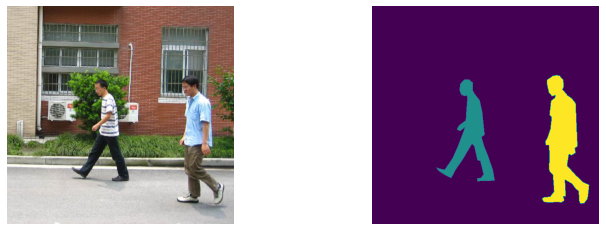

In [161]:
from PIL import Image
img  = np.asarray(Image.open('PennFudanPed/PNGImages/FudanPed00001.png'))
mask = np.asarray(Image.open('PennFudanPed/PedMasks/FudanPed00001_mask.png'))
_,axs = plt.subplots(1,2,figsize=(12,4));
axs[0].imshow(img); axs[0].axis('off');
axs[1].imshow(mask); axs[1].axis('off');plt.show()

Here we describing data in  `COCO` format. We will use `mask2box` for creating BBox from mask as image and `find_contours` to transform them to polygons for annotation. 

In [168]:
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image
from skimage.measure import find_contours

def mask2box(mask):
    pos = np.where(mask)
    xmin, xmax = np.min(pos[1]), np.max(pos[1])
    ymin, ymax = np.min(pos[0]), np.max(pos[0])
    return xmin, ymin,xmax-xmin, ymax-ymin

def pedestrian2COCO(root):

    imgs  = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
    masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))
    dataset_dicts = []
    for idx_im,(img_name, mask_name) in enumerate(zip(imgs, masks)):
        
        record = {}
        
        img_path  = os.path.join(root, "PNGImages", img_name)
        mask_path = os.path.join(root, "PedMasks",  mask_name)
        
        img  = np.array(Image.open(img_path).convert("RGB"))
        mask = np.array(Image.open(mask_path))
        obj_idxs = np.unique(mask)[1:]
        masks    = mask == obj_idxs[:, None, None]
        num_objs = len(obj_idxs)

        height, width = img.shape[:2]
        
        record["file_name"] = img_path
        record["image_id"]  = idx_im
        record["height"]    = height
        record["width"]     = width
        
        objs = []
        for mask in masks:#range(num_objs):
            poly = find_contours(mask.T)[0].reshape(-1,1).squeeze()
            obj = {
                "bbox": [*mask2box(mask)],
#                 "bbox_mode": BoxMode.XYWH_ABS,
                "segmentation": [poly],
                "category_id": 0,
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts, masks

Also we need to divide the data to train and test parts

In [169]:
dataset_dicts, masks = pedestrian2COCO('./PennFudanPed')
data_train = dataset_dicts[:-50]
val_train  = dataset_dicts[-50:]
print('train data: ',len(data_train))
print('valid data: ',len(val_train))

train data:  120
valid data:  50


./PennFudanPed\PNGImages\FudanPed00012.png


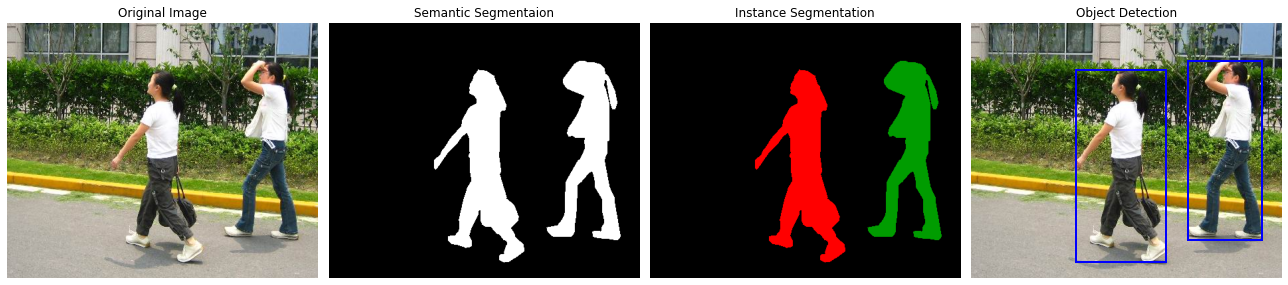

In [178]:
d = dataset_dicts[11]
print(d['file_name'])
image = np.asarray(Image.open(d["file_name"]))
masks_ = get_masks(d)
boxes_ = get_bboxes(d)
plot_instant(image, masks_, boxes_) 

Now you are able to train the network to that problem